In [21]:
# %pip install torchvision torch tqdm pillow opencv-python matplotlib ipywidgets segmentation_models_pytorch scikit-learn

In [10]:

import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
import sys
from tqdm import tqdm

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )
    
sys.path.insert(0, f"{os.path.abspath('')}/..")
from utils.logger import setup_folder_and_logger
experiment_folder, logger = setup_folder_and_logger(__name__)

using device: cuda


## SAM Utils

In [11]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True, savepath=None):
    fig, axes = plt.subplots(1, len(masks), figsize=(10*len(masks), 10))
    
    # Handle single mask case
    if len(masks) == 1:
        axes = [axes]
    
    for i, (mask, score) in enumerate(zip(masks, scores)):
        axes[i].imshow(image)
        show_mask(mask, axes[i], borders=borders)
        
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, axes[i])
        
        if box_coords is not None:
            show_box(box_coords, axes[i])
        
        axes[i].set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        axes[i].axis('off')
    
    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath)
    else:
        plt.show()
    plt.close()

## Example image

Loading dataset...


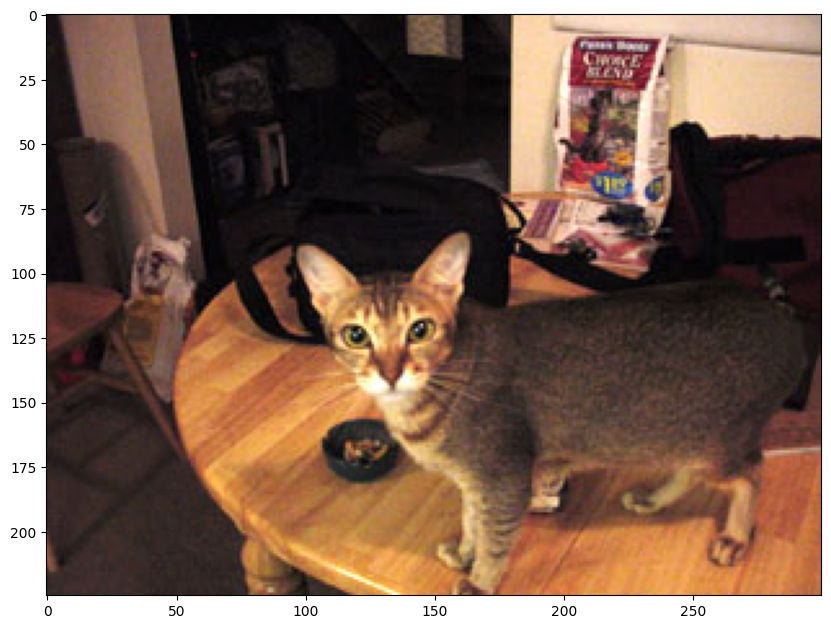

In [12]:
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader

# Load the dataset
print("Loading dataset...")
train_dataset = OxfordIIITPet(root='../data', 
                             split='trainval',
                             target_types=["category", "segmentation"],
                             download=True)

test_dataset = OxfordIIITPet(root='../data', 
                           split='test',
                           target_types=["category", "segmentation"],
                           download=True)

image = test_dataset[0][0]
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()


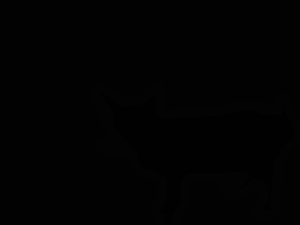

In [13]:
test_dataset[0][1][1]

## Import and test CAM

In [14]:
from cam import CAMModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# make new CAMModel and load the pre-trained weights
model = CAMModel()
model.load_state_dict(torch.load('./models/cam_model.pth', map_location=device, weights_only=False))
model = model.to(device)

idx = 0 # Change this index to visualize different images

# Apply transforms inside the predict method
output, img_tensor = model.predict(image)

# Generate CAM
pred_label, pred_cam = model.generate_cam(img_tensor)

# Convert original image to numpy array for plotting
original_np = np.array(image)

# Resize CAM to match original image size
cam_resized = cv2.resize(pred_cam, (image.width, image.height))

points = model.sample_cam_points(cam_resized)
# Plot overlay
# model.plot_cam_overlay(original_np, cam_resized, pred_label, sampled_points=points)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.0MB/s]


FileNotFoundError: [Errno 2] No such file or directory: './models/cam_model.pth'

## Load and test SAM

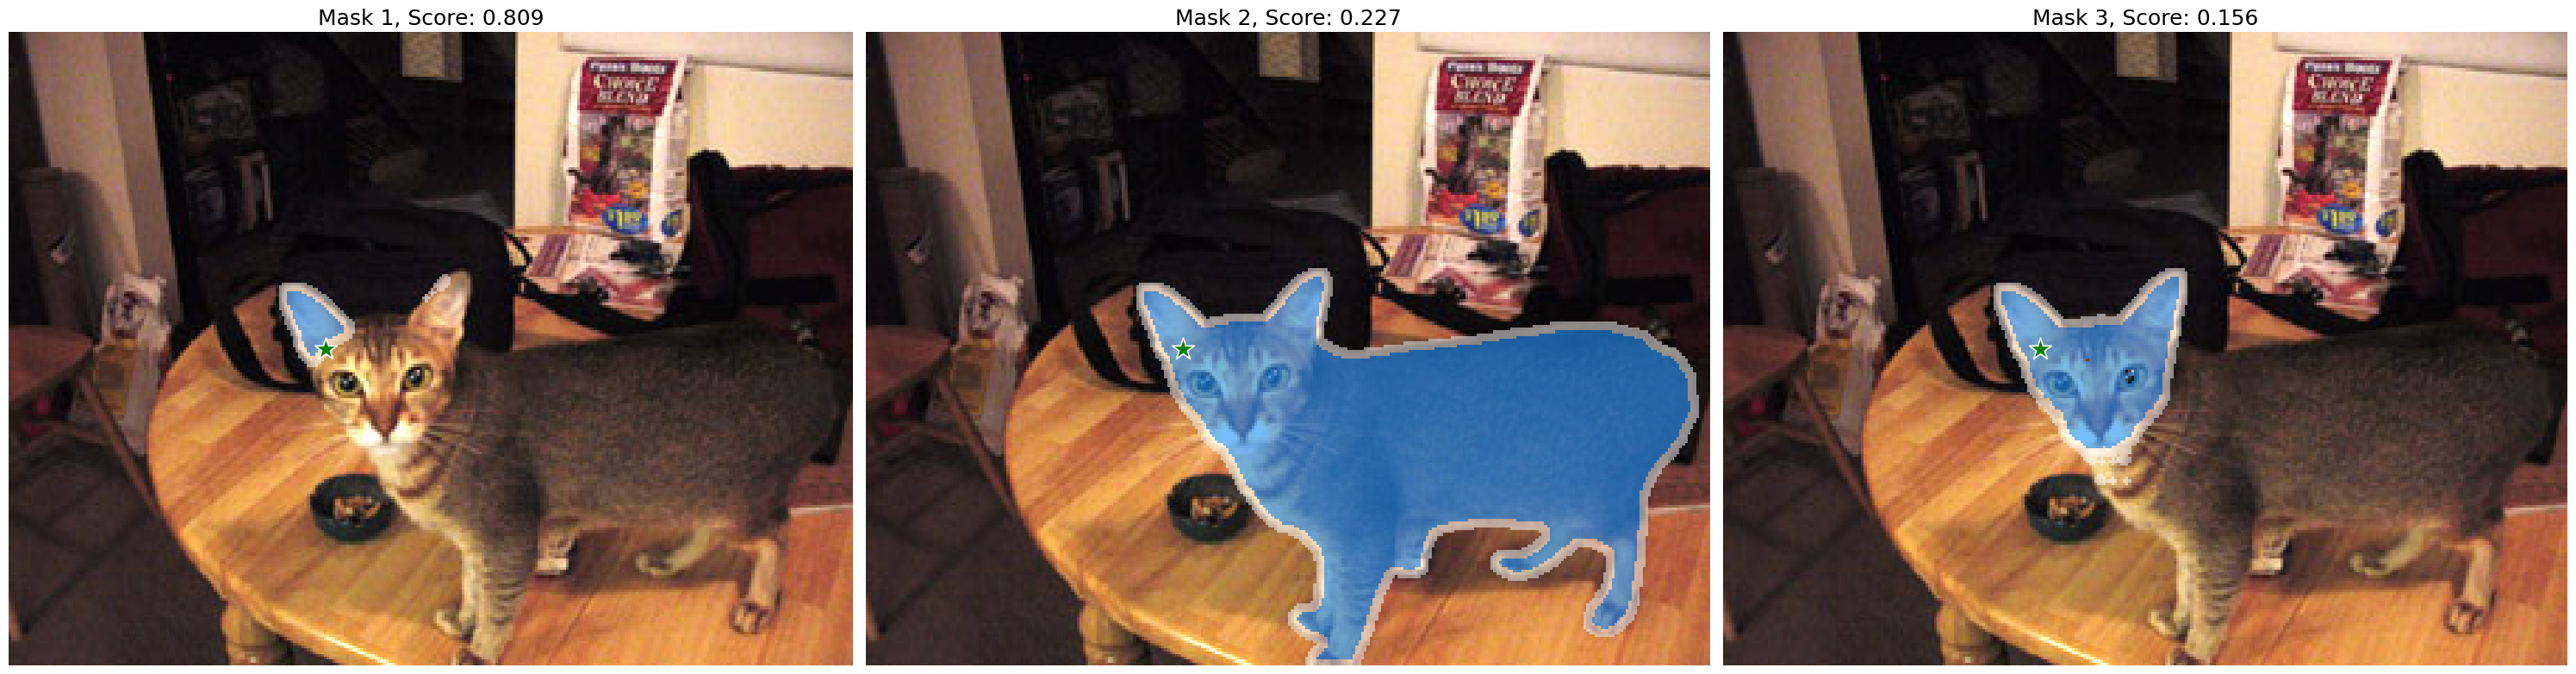

In [ ]:
sys.path.insert(0, f"{os.path.abspath('')}/sam2")
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "./models/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

points = np.array([[112,112]])
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=points,
    point_labels=np.repeat(1, len(points)),
    multimask_output=True,
)

sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]
mask_input = logits[np.argmax(scores), :, :]
masks, scores, _ = predictor.predict(
    point_coords=points,
    point_labels=np.repeat(1, len(points)),
    mask_input=mask_input[None, :, :],
    multimask_output=True,
)

# sort masks by score
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]

show_masks(image, masks, scores, point_coords=points, input_labels=np.repeat(1, len(points)), borders=True)

## Test run CAM+SAM - generates some sample to do sanity checking

In [ ]:
# randomly sample 10 samples
class_indices = np.random.choice(len(test_dataset), 10, replace=False)
class_indices = np.sort(class_indices)

for i, idx in enumerate(tqdm(class_indices)):
    image, label = test_dataset[idx]
    segmentation_label = label[1]
    label = label[0]
    class_ = test_dataset.classes[label].replace(" ", "_").lower()
    
    output, img_tensor = model.predict(image)
    pred_label, pred_cam = model.generate_cam(img_tensor, label)
    cam_resized = cv2.resize(pred_cam, (image.width, image.height))
    points = model.sample_cam_points(cam_resized, strategy='peak')
    model.plot_cam_overlay(np.array(image), cam_resized, pred_label, sampled_points=points, save_path=f'{experiment_folder}/cam_{class_}_{i}.png')

    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=points,
        point_labels=np.repeat(1, len(points)),
        multimask_output=True,
    )
    
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    mask_input = logits[np.argmax(scores), :, :]
    masks, scores, _ = predictor.predict(
        point_coords=points,
        point_labels=np.repeat(1, len(points)),
        mask_input=mask_input[None, :, :],
        multimask_output=True,
    )
    

    # logit_mask = logits[np.argmax(scores), :, :]
    logit_mask = np.sum(logits, axis=0)
    logit_mask = cv2.resize(logit_mask, (image.width, image.height))
    
    _, binary_cam_mask = cv2.threshold(cam_resized, 0.7, 1, cv2.THRESH_BINARY)
    # _, binary_logit_mask = cv2.threshold(logit_mask, -2, 1, cv2.THRESH_BINARY)
    
    heatmap = cv2.applyColorMap(np.uint8(255 * binary_cam_mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # overlay cam_resized onto image
    # print(np.array(image).shape) # (225, 300, 3)
    # print(heatmap.shape) # (225, 300, 3)
    overlay = cv2.addWeighted(np.array(image), 0.8, heatmap, 0.2, 0)
        
    # remove masks that have area smaller than binary_mask
    idx_to_keep = np.sum(masks, axis=(1, 2)) > np.sum(binary_cam_mask)
    if np.sum(idx_to_keep) > 0:
        masks = masks[idx_to_keep]
        scores = scores[idx_to_keep]

    # sort masks by score
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    
    # masks = np.concatenate([masks, binary_logit_mask[None, :, :]], axis=0)
    # scores = np.concatenate([scores, np.array([1.0])], axis=0)
    show_masks(overlay, masks, scores, point_coords=points, input_labels=np.repeat(1, len(points)), savepath=f'{experiment_folder}/sam_{class_}_{i}.png')

100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


## Evaluate on test set

In [16]:
import torch.utils.data
import functools
from torchvision import transforms

# Define a custom collate function that doesn't try to stack the PIL images
def custom_collate(batch):
    images = [item[0] for item in batch]  # Keep as list of PIL images
    # labels = [torch.tensor(item[1]) for item in batch]  # Convert labels to tensors
    # labels are now a integer (class) and a segmentation mask (PIL)
    labels = [item[1][0] for item in batch]  # Keep as integer class
    masks = [item[1][1] for item in batch]  # Keep as segmentation masks
    
    return images, labels, masks

# Define batch size
# Randomly sample 10 indices
num_samples = 18
BATCH_SIZE = 8
PLOT=False

np.random.seed(42)  # for reproducibility
selected_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

# Create a Subset of the dataset with just our selected indices
from torch.utils.data import Subset
selected_dataset = Subset(test_dataset, selected_indices)

# Create a DataLoader with custom collate function
dataloader = torch.utils.data.DataLoader(
    selected_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=custom_collate  # Use our custom collate function
)

In [19]:
# Process all batches
results = []
for batch_idx, batch in tqdm(enumerate(dataloader)):
    # Unpack batch
    images, labels, mask_labels = batch
    # segmentation_labels = [label[1] for label in labels]
    # labels = [label[0] for label in labels]
    
    print("Size of images: ", images[0].width, images[0].height)
    
    # Apply preprocessing in batch using map
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Convert images to tensors
    tensor_images = list(map(preprocess, images))
    tensor_batch = torch.stack(tensor_images)
    
    batch_pred_labels, batch_cams = model.batch_generate_cam(tensor_batch, labels)
    
    logger.info(f"True labels: {labels} Predicted labels: {batch_pred_labels}")

    # Resize CAM back to the individual image's dimensions
    for i, cam in enumerate(batch_cams):
        image = images[i]
        cam_resized = cv2.resize(cam, (image.width, image.height))
        batch_cams[i] = cam_resized
        
    batch_points = list(map(functools.partial(model.sample_cam_points, strategy='peak'), batch_cams))
    
    # Process each image with its CAM
    for i, (image, label, cam_resized, points) in enumerate(zip(images, labels, batch_cams, batch_points)):
        
        if PLOT:
            model.plot_cam_overlay(
                np.array(image),
                cam_resized, 
                label, 
                sampled_points=points, 
                save_path=f'{experiment_folder}/sam_{batch_idx}_{class_}.png'
            )
        
        
        # SAM the CAM
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(
            point_coords=points,
            point_labels=np.repeat(1, len(points)),
            multimask_output=True,
        )
        
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]
        mask_input = logits[np.argmax(scores), :, :]
        masks, scores, _ = predictor.predict(
            point_coords=points,
            point_labels=np.repeat(1, len(points)),
            mask_input=mask_input[None, :, :],
            multimask_output=True,
        )
        

        # logit_mask = logits[np.argmax(scores), :, :]
        logit_mask = np.sum(logits, axis=0)
        logit_mask = cv2.resize(logit_mask, (image.width, image.height))
        
        _, binary_cam_mask = cv2.threshold(cam_resized, 0.7, 1, cv2.THRESH_BINARY)
        # _, binary_logit_mask = cv2.threshold(logit_mask, -2, 1, cv2.THRESH_BINARY)
        
        heatmap = cv2.applyColorMap(np.uint8(255 * binary_cam_mask), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # overlay cam_resized onto image
        # print(np.array(image).shape) # (225, 300, 3)
        # print(heatmap.shape) # (225, 300, 3)
        overlay = cv2.addWeighted(np.array(image), 0.8, heatmap, 0.2, 0)
            
        # remove masks that have area smaller than binary_mask
        idx_to_keep = np.sum(masks, axis=(1, 2)) > np.sum(binary_cam_mask)
        if np.sum(idx_to_keep) > 0:
            masks = masks[idx_to_keep]
            scores = scores[idx_to_keep]

        # sort masks by score
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]

        if PLOT:
            show_masks(overlay, masks, scores, point_coords=points, input_labels=np.repeat(1, len(points)), savepath=f'{experiment_folder}/sam_{batch_idx}_{class_}.png')

        # Save results in compressed format to calculate metrics later
        results.append({
            "pred_labels": batch_pred_labels[i],
            "true_labels": label,
            "masks": masks.astype(np.uint8),
            "mask_labels": np.array(mask_labels[i]),
        })

# save results
import pickle
with open(f"{experiment_folder}/results.pkl", "wb") as f:
    pickle.dump(results, f)
    

# load results
with open(f"{experiment_folder}/results.pkl", "rb") as f:
    results = pickle.load(f)


0it [00:00, ?it/s]

Size of images:  334 500
2025-03-29 15:29:23,523 - __main__ - INFO - True labels: [1, 26, 31, 10, 11, 22, 23, 1] Predicted labels: [1, 26, 31, 10, 11, 22, 23, 1]
2025-03-29 15:29:23,523 - __main__ - INFO - True labels: [1, 26, 31, 10, 11, 22, 23, 1] Predicted labels: [1, 26, 31, 10, 11, 22, 23, 1]
2025-03-29 15:29:23,523 - __main__ - INFO - True labels: [1, 26, 31, 10, 11, 22, 23, 1] Predicted labels: [1, 26, 31, 10, 11, 22, 23, 1]


0it [00:01, ?it/s]


NameError: name 'predictor' is not defined

In [ ]:
from utils.metrics import evaluate_and_visualize_trimaps
# Run evaluation and visualization
metrics = evaluate_and_visualize_trimaps(results, experiment_folder, iou_threshold=0.5)

# Access metrics if needed
print(f"Classification accuracy: {metrics['classification_accuracy']}")
print(f"Average IoU: {metrics['avg_metrics']['iou']}")


CLASSIFICATION METRICS:
Accuracy: 1.0000

SEGMENTATION METRICS (evaluated on non-ambiguous regions only):
Mean IoU: 0.7630 ± 0.2091
Mean Dice: 0.8402 ± 0.2170
Mean Pixel Precision: 0.7682 ± 0.2072
Mean Pixel Recall: 0.9353 ± 0.2340
Mean Pixel Accuracy: 0.8038 ± 0.1820
Mean Boundary F1: 0.0112 ± 0.0109
Correct Mask Ratio (IoU > 0.5): 0.8889
Samples with GT masks: 18/18
Samples with predicted masks: 18/18
Classification accuracy: 1.0
Average IoU: 0.7630063864916853
